# Matchup Analysis

### MSP 7.1.2017

It's time. Fivethirtyeight has their model, we need one of our own.

This model will update daily.

In [1]:
from IPython.display import HTML
HTML('''<script>code_show=true; function code_toggle() { if (code_show){ $('div.input').hide();} else { $('div.input').show(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
# boilerplate imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
# imports for scraping

from bs4 import BeautifulSoup

import requests


In [3]:
teams = ['angels','astros','athletics','bluejays','braves',\
        'brewers','cardinals','cubs','diamondbacks','dodgers',\
        'giants','indians','mariners','marlins','mets','nationals',\
        'orioles','padres','phillies','pirates','rangers',\
        'rays','redsox','rockies','royals','tigers','twins',\
        'whitesox','yankees']

# can go back seasons with ?season=2016 at end of url

In [47]:
# get twins data
#teams = ['twins']

Schedule = {}


for inteam in teams:
    
    print inteam
    
    Schedule[inteam] = {}
    
    r  = requests.get('http://www.fangraphs.com/teams/'+inteam+'/schedule')

    data = r.text

    soup = BeautifulSoup(data)

    table_div = soup.find('div' , {"class":"team-schedule-table"})
    table = table_div.find('table')

    # The first tr contains the field names.
    headings = [th.get_text() for th in table.find("tr").find_all("th")]

    # get number of games played
    ngames = 0
    for row in table.find_all("tr")[1:]:
        if [td.get_text() for td in row.find_all("td")][5] != '':
            ngames += 1       
        

    headings[3] = 'HomeWin'
    headings[5] = 'HomeRuns'
    headings[7] = 'HomeStarter'

    #print headings


    for indx,val in enumerate(headings):
        Schedule[inteam][val] = np.empty(ngames,dtype='S20')

    game = 0
    for row in table.find_all("tr")[1:]:
        if [td.get_text() for td in row.find_all("td")][5] != '':
            for indx,val in enumerate(headings):
                Schedule[inteam][val][game] = [td.get_text().decode() for td in row.find_all("td")][indx]
            game += 1


angels
astros
athletics
bluejays
braves
brewers
cardinals
cubs
diamondbacks
dodgers
giants
indians
mariners
marlins
mets
nationals
orioles
padres
phillies
pirates
rangers
rays
redsox
rockies
royals
tigers
twins
whitesox
yankees


In [48]:

for inteam in teams:

    print '{0:<12s} {1:>6.1f}'.format(\
     inteam,np.sum(Schedule[inteam]['HomeRuns'].astype(float) - Schedule[inteam]['OppRuns'].astype(float)))
                                 
                                 

angels         -6.0
astros        117.0
athletics     -81.0
bluejays      -31.0
braves        -37.0
brewers        23.0
cardinals       7.0
cubs           10.0
diamondbacks  109.0
dodgers       155.0
giants        -88.0
indians        56.0
mariners       -2.0
marlins       -31.0
mets          -27.0
nationals      87.0
orioles       -74.0
padres       -122.0
phillies      -97.0
pirates       -36.0
rangers        23.0
rays           24.0
redsox         49.0
rockies        32.0
royals        -31.0
tigers        -22.0
twins         -55.0
whitesox      -17.0
yankees       111.0


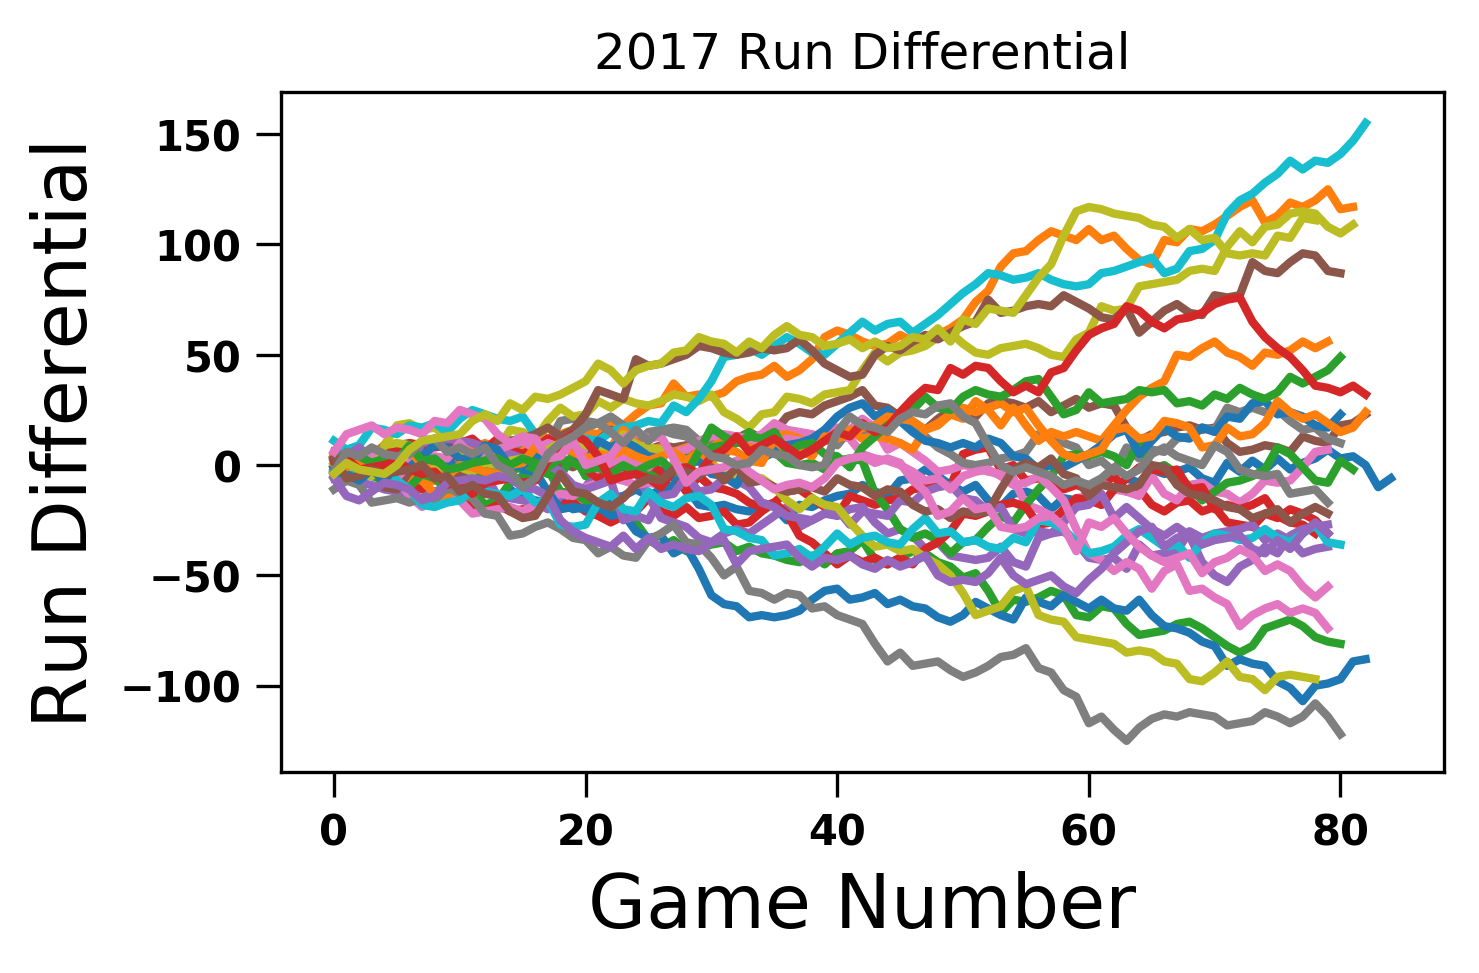

In [49]:
plt.figure(figsize=(5,3))



for inteam in teams:

    plt.plot(np.cumsum(Schedule[inteam]['HomeRuns'].astype(float) - Schedule[inteam]['OppRuns'].astype(float)))
    
    
plt.title('2017 Run Differential')
plt.xlabel('Game Number',size=18)    
plt.ylabel('Run Differential',size=18)

Quick thoughts:
1. What's going on with the Orioles??
2. Padres look like they have a commanding lead on being bad.
3. Dodgers look very good on the top end.

### Goal: make a model for teams facing each other that can be built from.


### Checkpoint: Examining starters

What kind of a lead or deficit are starters leaving with?

In [50]:
#http://www.fangraphs.com/wins.aspx?date=2017-04-03&team=Twins&dh=0&season=2017
    
teams2 = ['rangers']

GameLog = {}


for inteam in teams2:
    
    print inteam

    
    r  = requests.get('http://www.fangraphs.com/teams/'+inteam+'/schedule')

    data = r.text

    soup = BeautifulSoup(data)

    table_div = soup.find('div' , {"class":"team-schedule-table"})
    table = table_div.find('table')

    # The first tr contains the field names.
    headings = [th.get_text() for th in table.find("tr").find_all("th")]

    # get number of games played
    ngames = 0
    for row in table.find_all("tr")[1:]:
        if [td.get_text() for td in row.find_all("td")][5] != '':
            GameLog[ngames] = {}
            sav = [td.find('a') for td in row.find_all("td")][0]
            GameLog[ngames]['link'] = sav.get('href')[0:25]+'plays'+sav.get('href')[29:]
            GameLog[ngames]['oppo'] = [td.get_text() for td in row.find_all("td")][8]
            GameLog[ngames]['home'] = [td.get_text() for td in row.find_all("td")][7]
            ngames += 1       
        


#print GameLog[10]

rangers


In [53]:
#teams2 = ['twins']


starter_off = np.zeros(len(GameLog.keys()))
starter_def = np.zeros(len(GameLog.keys()))

for inteam in teams2:
    
    print inteam


    
    for indx,key in enumerate(GameLog.keys()):
 
        print 'Game number: ',indx+1,
    
        r  = requests.get(GameLog[key]['link'])
    
        #print GameLog[key]['link']
        print GameLog[key]['oppo'],

        data = r.text
    
        soup = BeautifulSoup(data)

        table = soup.findAll('table')[8]
        # The first tr contains the field names.
        headings = [th.get_text() for th in table.find("tr").find_all("th")]

        #print headings
        # get number of games played
        #ngames = 0
        nruns_o = 0.
        nruns_d = 0.
        for row in table.find_all("tr")[1:]:
            if GameLog[key]['oppo'].split()[1] in [td.get_text() for td in row.find_all("td")][0]:
                up = int([td.get_text() for td in row.find_all("td")][13])
                #print ~int([td.get_text() for td in row.find_all("td")][13])
                breakscore = [td.get_text() for td in row.find_all("td")][5].split('-')
                #print up,breakscore[0],breakscore[1]
                
                if up:
                    tmpruns_o = float(breakscore[0])
                    tmpruns_d = float(breakscore[1])
                else:
                    tmpruns_o = float(breakscore[1])
                    tmpruns_d = float(breakscore[0])
                    
                nruns_o = np.max([nruns_o,tmpruns_o])
                nruns_d = np.max([nruns_d,tmpruns_d])
                
        print nruns_o
        
        starter_off[indx] = nruns_o # runs scored by team
        starter_def[indx] = nruns_d # runs scored against team



rangers
Game number:  1 Corey Kluber 5.0
Game number:  2 Carlos Carrasco 2.0
Game number:  3 Danny Salazar 5.0
Game number:  4 Raul Alcantara 8.0
Game number:  5 Kendall Graveman 1.0
Game number:  6 Sean Manaea 3.0
Game number:  7 Tyler Skaggs 5.0
Game number:  8 Jesse Chavez 5.0
Game number:  9 Ricky Nolasco 5.0
Game number:  10 Felix Hernandez 1.0
Game number:  11 James Paxton 0.0
Game number:  12 Hisashi Iwakuma 6.0
Game number:  13 Jharel Cotton 5.0
Game number:  14 Andrew Triggs 2.0
Game number:  15 Jesse Hahn 1.0
Game number:  16 Danny Duffy 0.0
Game number:  17 Nathan Karns 6.0
Game number:  18 Ian Kennedy 1.0
Game number:  19 Jason Hammel 2.0
Game number:  20 Phil Hughes 2.0
Game number:  21 Ervin Santana 1.0
Game number:  22 Hector Santiago 2.0
Game number:  23 Tyler Skaggs 1.0
Game number:  24 Jesse Chavez 4.0
Game number:  25 JC Ramirez 2.0
Game number:  26 Lance McCullers 2.0
Game number:  27 Mike Fiers 5.0
Game number:  28 Charlie Morton 1.0
Game number:  29 Joe Musgrove 5

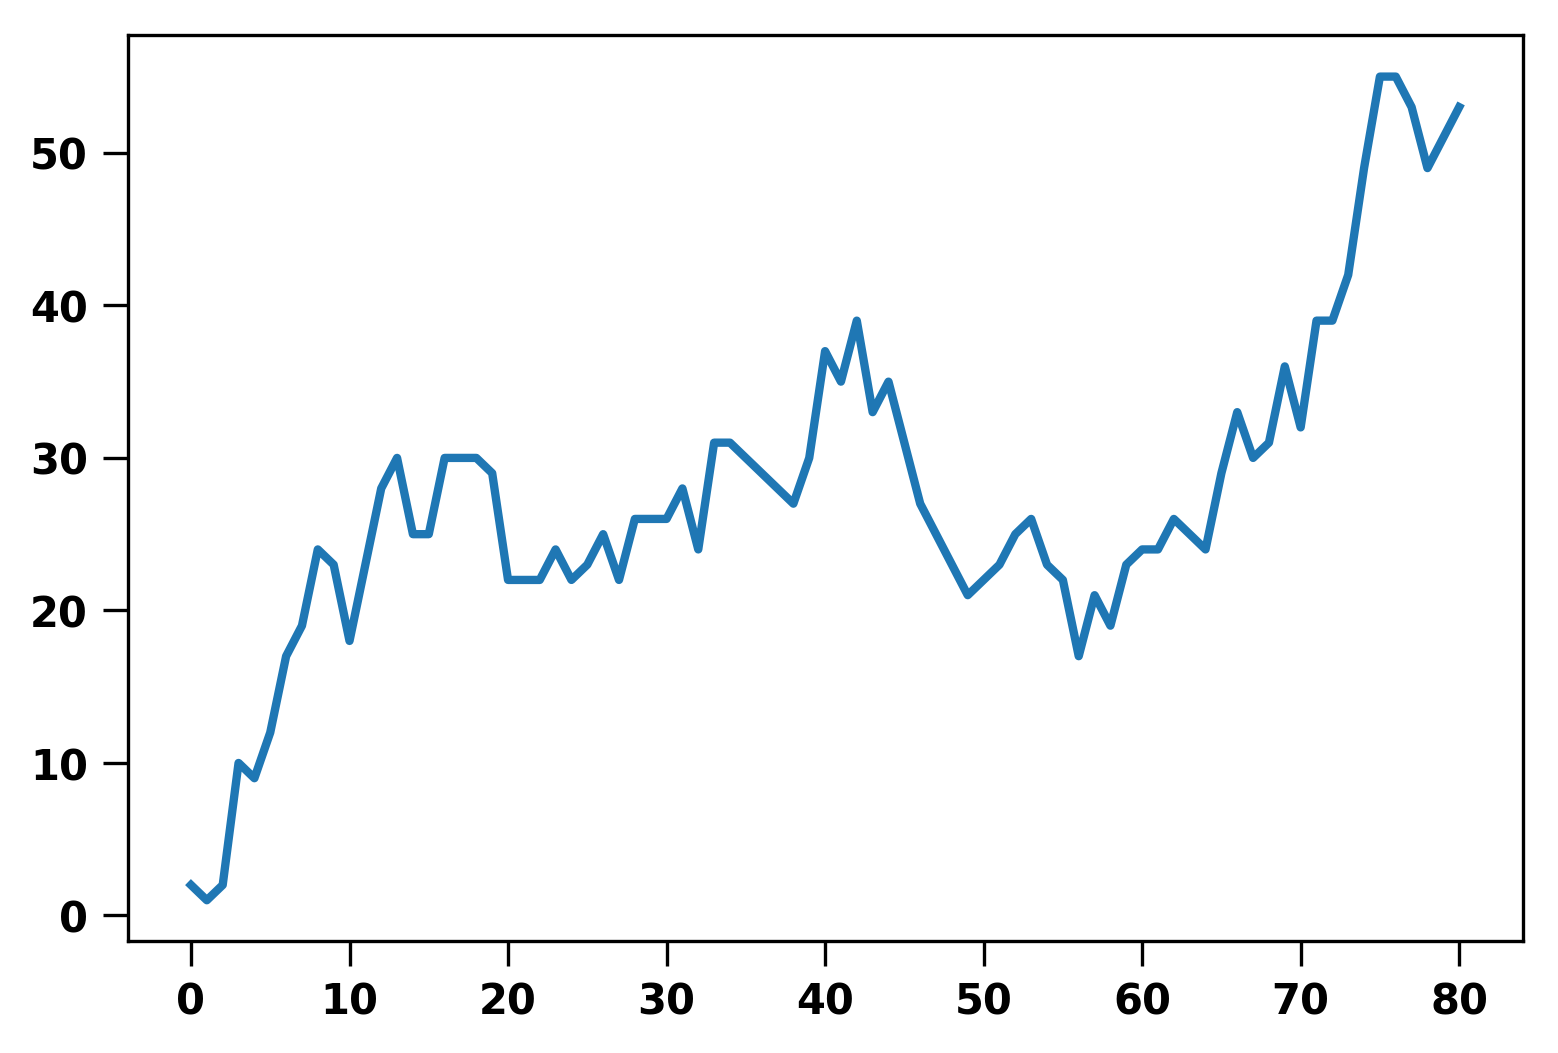

In [52]:
plt.plot(np.cumsum(starter_off-starter_def))